In [1]:
import torch # torch
import torch.nn as nn # neural networks
import torch.nn.functional as F # layers, activations and more
from torch.utils.data import DataLoader # gives easier dataset management and creates mini batches
from torchvision import datasets, transforms # datasets and transforms
import numpy as np # numpy
import pandas as pd # pandas
from sklearn.metrics import confusion_matrix # for confusion matrix
import matplotlib.pyplot as plt # matplotlib

In [2]:
#MNIST Dataset
transform = transforms.ToTensor() # transform it into a torch tensor

In [3]:
#training data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform) # download and transform the training data


In [4]:
#testing data
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform) # download and transform the testing data

In [5]:
#training data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
#test data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
image, label = train_data[0] # get the first image and its label
print('image.shape:', image.shape) # print the image shape
# answer: image.shape: torch.Size([1, 28, 28]) and it is a 1 channel image of 28x28 pixels

image.shape: torch.Size([1, 28, 28])


In [8]:
label # print the label
#answer: 5 (the label is a number)

5

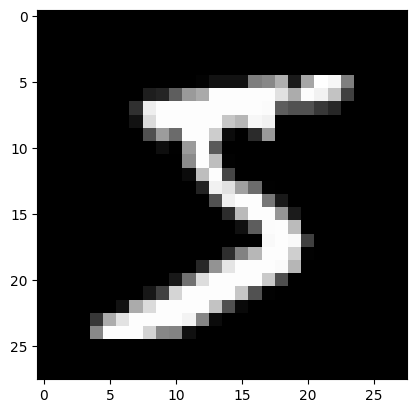

In [9]:
plt.imshow(image.reshape((28,28)), cmap='gray') # plot the image as grayscale
#reshape the image to 28x28 pixels, 
# because the image is 1x28x28 pixels and we need to remove the 1 channel dimension to plot it as a 28x28 image with plt.imshow function of matplotlib library.
plt.show() # show the image

In [10]:
torch.manual_seed(101) # set the random seed so things are reproducible 
#reproducible means that the same random numbers are generated every time the program is run.
train_loader = DataLoader(train_data, batch_size=100, shuffle=True) # create the train_loader with DataLoader
test_loader = DataLoader(test_data, batch_size=500, shuffle=False) # create the test_loader with DataLoader

In [11]:
from torchvision.utils import make_grid # for making a grid of images
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # set the numpy print options to 4 spaces


In [12]:
# First we get a batch of images
for images,labels in train_loader:
    #60,000 images in the training set, 
    # and we are using a batch size of 100, 
    # so we will have 600 batches of 100 images each.
    break # break the loop after one iteration

In [13]:
images.shape # print the image shape
#answer: torch.Size([100, 1, 28, 28]), 
# because we are using a batch size of 100.

torch.Size([100, 1, 28, 28])

In [14]:
labels.shape # print the label shape
#answer: torch.Size([100]),
# because we are using a batch size of 100.

torch.Size([100])

labels: [   7    2    3    5    8    5    3    6    9    9    1    3]


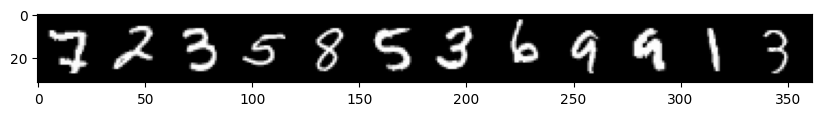

In [15]:
print('labels:', labels[:12].numpy()) # print the first 12 labels
img = make_grid(images[:12], nrow=12) # make a grid of the first 12 images
plt.figure(figsize=(10,4)) # set the figure size
plt.imshow(np.transpose(img, (1,2,0))) # plot the grid of images
#transpose the image to 28x28 pixels, 
# transpose function is used to convert the dimensions of an array.
plt.show() # show the images

In [16]:
#creating the model
class ANN(nn.Module): # inherit from nn.Module
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]): # constructor
        #in_sz: input size, out_sz: output size, layers: list of hidden layer sizes
        #784: 28x28 pixels, 10: 10 classes, [120,84]: two hidden layers with 120 and 84 neurons respectively
        super().__init__() # inherit from nn.Module
        self.fc1 = nn.Linear(in_sz, layers[0]) # first layer
        self.fc2 = nn.Linear(layers[0], layers[1]) # second layer
        #self.fc1 and self.fc2 are the weights and biases of the first and second layers respectively.
        self.out = nn.Linear(layers[1], out_sz) # output layer
        #self.out is the weights and biases of the output layer.
        
    def forward(self, X): # forward propagation function
        #activation function: ReLU, and output activation function: log softmax
        X = F.relu(self.fc1(X)) # activation function for first layer
        X = F.relu(self.fc2(X)) # activation function for second layer
        X = self.out(X) # output layer
        return F.log_softmax(X, dim=1) # activation function for output layer
        #dim=1: the dimension along which the softmax will be computed

In [17]:
torch.manual_seed(101) # set the random seed so things are reproducible
model = ANN() # create the ANN model
model # print the model

ANN(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

ANN --> CNN (Convolutional Neural Network)
CNN is a type of ANN that is used for image classification.
CNN is a type of ANN that is used for image classification.
Better than ANN because it uses less parameters and it is faster.

In [18]:
#ANN --> CNN
for param in model.parameters():
    print(param.numel()) # print the number of elements in each parameter tensor

94080
120
10080
84
840
10


In [19]:
critereon = nn.CrossEntropyLoss() # create the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # create the optimizer

In [20]:
images.shape # print the image shape
#we need to flatten the images to 784 pixels, 
#because the input size of the model is 784 pixels.
#answer: torch.Size([100, 1, 28, 28]) but we need torch.Size([100, 784])

torch.Size([100, 1, 28, 28])

In [21]:
images.view(100, -1).shape # flatten the images to 784 pixels

torch.Size([100, 784])

In [22]:
import time # time
start_time = time.time() # get the start time

#training the model

epochs = 10 # number of epochs

# Track the loss and accuracy on the test set to determine the best performance of the model
train_losses = [] # to store the training losses
test_losses = [] # to store the testing losses
train_correct = [] # to store the number of correct predictions during training
test_correct = [] # to store the number of correct predictions during testing

for i in range(epochs): # loop over the epochs
    trn_corr = 0 # correct predictions in the training set
    tst_corr = 0 # correct predictions in the testing set

    for b, (X_train, y_train) in enumerate(train_loader): # b: batch number, X_train: images, y_train: labels
        b+=1 # update the batch number

        y_pred = model(X_train.view(100, -1)) # pass the reshaped images to the model
        loss = critereon(y_pred, y_train) # calculate the loss

        predicted = torch.max(y_pred.data, 1)[1] # get the index of the max log-probability
        batch_corr = (predicted == y_train).sum() # get the number of correct predictions in the batch
        trn_corr += batch_corr # update the training correct predictions

        optimizer.zero_grad() # clear the gradients of all optimized variables
        loss.backward() # backward pass: compute the gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)

        if b%200 == 0: # print the loss and accuracy every 200 batches
            acc = trn_corr.item()*100/(100*b) # calculate the accuracy
            print(f'Epoch {i+1} batch {b} loss: {loss.item()} accuracy:{acc}')

    train_losses.append(loss.detach().numpy()) # append the training loss
    train_correct.append(trn_corr) # append the training accuracy

    with torch.no_grad(): # we don't need to calculate the gradients in the testing phase
        for b, (X_test, y_test) in enumerate(test_loader): # b: batch number, X_test: images, y_test: labels
            y_val = model(X_test.view(500, -1)) # pass the reshaped images to the model
            predicted = torch.max(y_val.data, 1)[1] # get the index of the max log-probability
            tst_corr += (predicted == y_test).sum() # get the number of correct predictions in the batch
    
    loss = critereon(y_val, y_test) # calculate the loss
    test_losses.append(loss) # append the testing loss
    test_correct.append(tst_corr) # append the testing accuracy



total_time = time.time() - start_time # get the total time
print(f'Duration: {total_time/60} mins') # print the duration in minutes

Epoch 1 batch 200 loss: 0.2354806363582611 accuracy:83.25
Epoch 1 batch 400 loss: 0.35484227538108826 accuracy:87.525
Epoch 1 batch 600 loss: 0.13819032907485962 accuracy:89.57833333333333
Epoch 2 batch 200 loss: 0.24292698502540588 accuracy:94.885
Epoch 2 batch 400 loss: 0.14360255002975464 accuracy:95.1025
Epoch 2 batch 600 loss: 0.07438161224126816 accuracy:95.36166666666666
Epoch 3 batch 200 loss: 0.0879400447010994 accuracy:96.545
Epoch 3 batch 400 loss: 0.0586220845580101 accuracy:96.6525
Epoch 3 batch 600 loss: 0.07008299231529236 accuracy:96.72
Epoch 4 batch 200 loss: 0.12146606296300888 accuracy:97.695
Epoch 4 batch 400 loss: 0.05574993044137955 accuracy:97.5025
Epoch 4 batch 600 loss: 0.03278490900993347 accuracy:97.54333333333334
Epoch 5 batch 200 loss: 0.11401800066232681 accuracy:98.16
Epoch 5 batch 400 loss: 0.04410777613520622 accuracy:98.005
Epoch 5 batch 600 loss: 0.047576114535331726 accuracy:98.01
Epoch 6 batch 200 loss: 0.010225486010313034 accuracy:98.415
Epoch 6 b

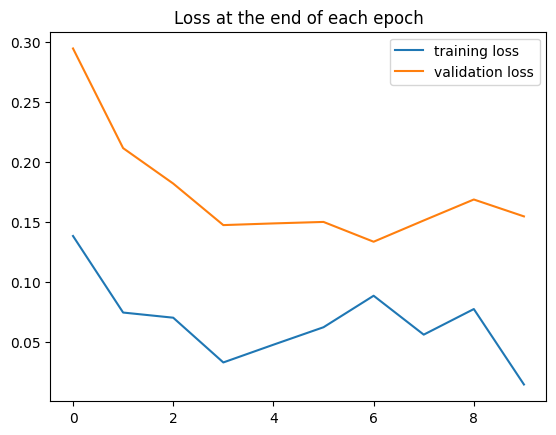

In [23]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

In [24]:
train_acc = [t/600 for t in train_correct] # calculate the training accuracy

In [25]:
test_acc = [t/100 for t in test_correct] # calculate the testing accuracy

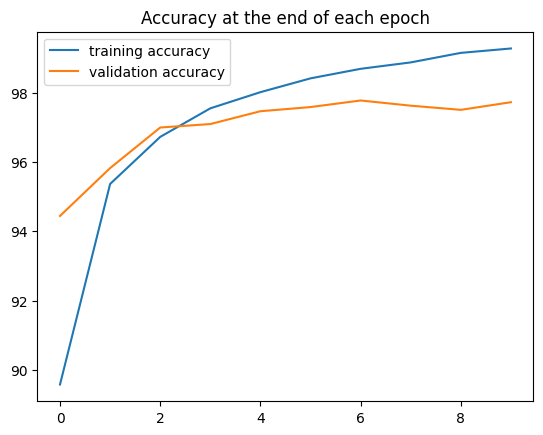

In [26]:
plt.plot(train_acc, label='training accuracy')
plt.plot(test_acc, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [27]:
# New unseen data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False) # create the test data loader, batch size is 10000, shuffle is False.
with torch.no_grad(): # we don't need to calculate the gradients in the testing phase
    correct = 0 # correct predictions
    for X_test, y_test in test_load_all: # X_test: images, y_test: labels
        y_val = model(X_test.view(len(X_test), -1)) # pass the reshaped images to the model
        predicted = torch.max(y_val,1)[1] # get the index of the max log-probability
        correct += (predicted == y_test).sum() # get the number of correct predictions
        

In [29]:
print(100 * correct.item() / len(test_data)) # print the number of correct predictions

97.72


In [30]:
confusion_matrix(y_test.view(-1), predicted.view(-1)) # create the confusion matrix

array([[ 974,    0,    1,    2,    0,    0,    1,    0,    2,    0],
       [   0, 1124,    3,    3,    0,    0,    2,    0,    3,    0],
       [   5,    3,  998,    8,    3,    0,    2,    4,    9,    0],
       [   0,    0,    2,  992,    0,    5,    0,    2,    4,    5],
       [   2,    0,    2,    0,  966,    0,    4,    1,    0,    7],
       [   2,    0,    0,   12,    3,  862,    4,    1,    5,    3],
       [   5,    2,    1,    1,    3,    3,  942,    0,    1,    0],
       [   3,    6,    9,    2,    3,    1,    0,  983,    3,   18],
       [   7,    0,    2,    3,    4,    4,    1,    2,  946,    5],
       [   3,    2,    0,    2,   11,    3,    0,    0,    3,  985]])

## Done